In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import interact, interactive, fixed

%matplotlib inline

failed to find corner on: ./camera_cal/calibration1.jpg
failed to find corner on: ./camera_cal/calibration4.jpg
failed to find corner on: ./camera_cal/calibration5.jpg


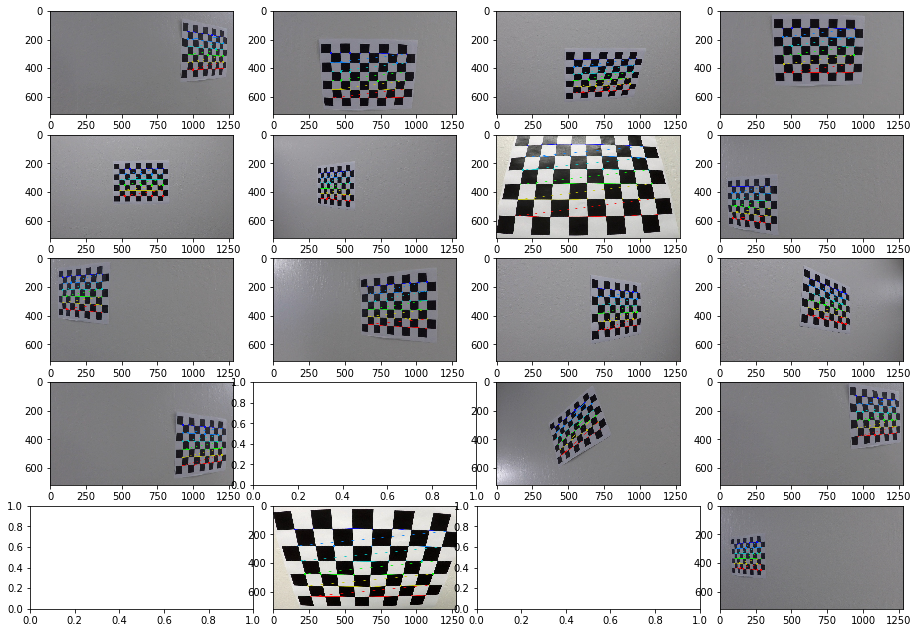

In [2]:
#Step 1. Calibrate camera
#1.1 find chessboard corners and get the calibration matrix
import glob
camera_cals = glob.glob("./camera_cal/*.jpg")
nx=9
ny=6

objpoints = []
imgpoints = []
objp = np.zeros((nx*ny,3), np.float32)
objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)# initialize x, y coordinates to grid, z to zero
calibration_imgs = []

fig, axs = plt.subplots(5,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

w = h = 0
for i, imgf in enumerate(camera_cals):
    img =mpimg.imread(imgf) 
    calibration_imgs.append(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if not ret:
        print("failed to find corner on:", imgf)
    else:    
        imgpoints.append(corners)
        objpoints.append(objp)
        img_t = img.copy()
        img_t = cv2.drawChessboardCorners(img_t, (nx,ny), corners, ret)
        axs[i].imshow(img_t)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (w, h), None, None)

Failed in finding corners for 3 images with given number of chessboard corners so they don't appear here.

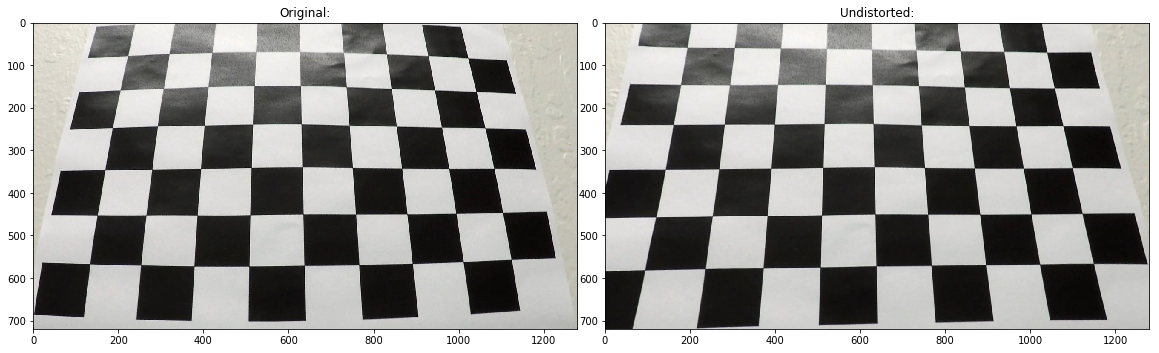

In [3]:
#Check distort correction with one of calibration images
img = calibration_imgs[6]
undst = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original:')
ax2.imshow(undst)
ax2.set_title('Undistorted:')

In [4]:
#load test images
tests = sorted(glob.glob("./test_images/*.jpg"))
n = len(tests)
test_imgs = []
w = h = 0
for i, imgf in enumerate(tests):
    img = cv2.imread(imgf)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    w,h = img.shape[1::-1]
    test_imgs.append(img)
    print (i, imgf)

0 ./test_images/straight_lines1.jpg
1 ./test_images/straight_lines2.jpg
2 ./test_images/test1.jpg
3 ./test_images/test2.jpg
4 ./test_images/test3.jpg
5 ./test_images/test4.jpg
6 ./test_images/test5.jpg
7 ./test_images/test6.jpg


In [31]:
#Use straight lane images to select the source/destination points.

src = np.float32([[582,460],[703,460],[1110,720],[202,720]])

ROI = np.float32([[560,440],[720,440],[1130,720],[180,720]])
offset = 300
dst = np.float32([[offset, 0], [1280-offset,0], [1280-offset, 720],[offset, 720]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)
def unwarp(img):
    unwarped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    return unwarped


Next step is to do a perspective transform

[  582.   703.  1110.   202.   582.] [ 460.  460.  720.  720.  460.]


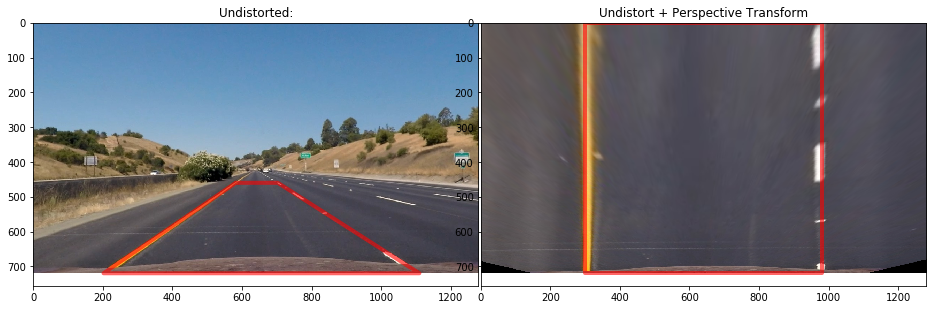

In [38]:
img = test_imgs[0].copy()
undist = undistort(img)
#do the perspective transform on an undistorted image
warped = unwarp(undist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
f.subplots_adjust(hspace = .2, wspace=.005)
ax1.imshow(undist)
#overlay the source points trapezoid
x = src[:,0]
y = src[:,1]
x = np.append(x, src[0][0])
y = np.append(y, src[0][1])
ax1.plot(x, y, color='red', alpha=0.6, linewidth=4, solid_capstyle='round', zorder=2)
print (x, y)
#ax1.set_ylim([h,0])
#ax1.set_xlim([0,w])
ax1.set_title('Undistorted:')

ax2.imshow(warped)
#overlay the destination points rectangle 
x = dst[:,0]
y = dst[:,1]
x = np.append(x, dst[0][0])
y = np.append(y, dst[0][1])
ax2.plot(x, y, color='red', alpha=0.6, linewidth=4, solid_capstyle='round', zorder=2)
ax2.set_title('Undistort + Perspective Transform')


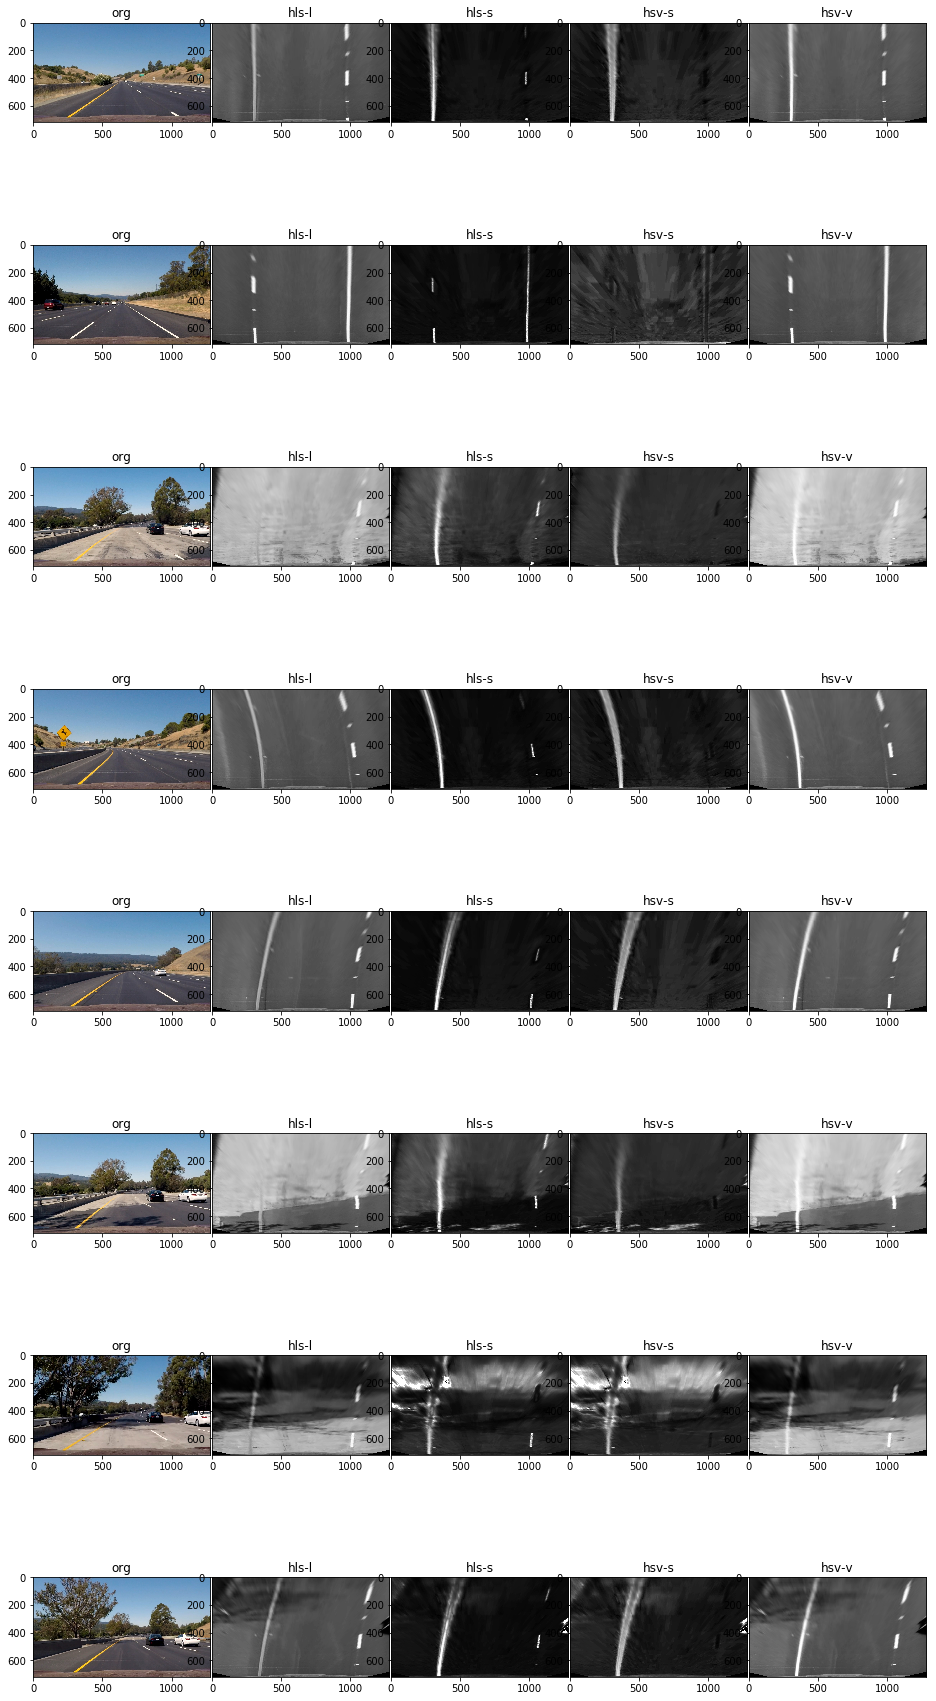

In [36]:
f, axs = plt.subplots(8, 5, figsize=(16,32))
f.subplots_adjust(hspace =.2, wspace=.01)
axs = axs.ravel()

for i,img in enumerate(test_imgs):
    warped = unwarp(undistort(img))
    hls_l = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)[:,:,1]
    hls_s = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)[:,:,2]
    hsv_s = cv2.cvtColor(warped, cv2.COLOR_RGB2HSV)[:,:,1]
    hsv_v = cv2.cvtColor(warped, cv2.COLOR_RGB2HSV)[:,:,2]
    
    axs[5*i].imshow(img)
    axs[5*i].set_title('org')
    axs[5*i+1].imshow(hls_l, cmap='gray')
    axs[5*i+1].set_title('hls-l')
    axs[5*i+2].imshow(hls_s,cmap='gray')
    axs[5*i+2].set_title('hls-s')
    axs[5*i+3].imshow(hsv_s,cmap='gray')
    axs[5*i+3].set_title('hsv-s')
    axs[5*i+4].imshow(hsv_v,cmap='gray')
    axs[5*i+4].set_title('hsv-v')

both HSV V channel (HSV:V) and HLS S channel(HLS:S) can caputre the wihte and yellow lines and seperate them out of background well. 

In [7]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # If img is in RGB format, Convert to grayscale
    if len(img.shape) > 2:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y'))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output


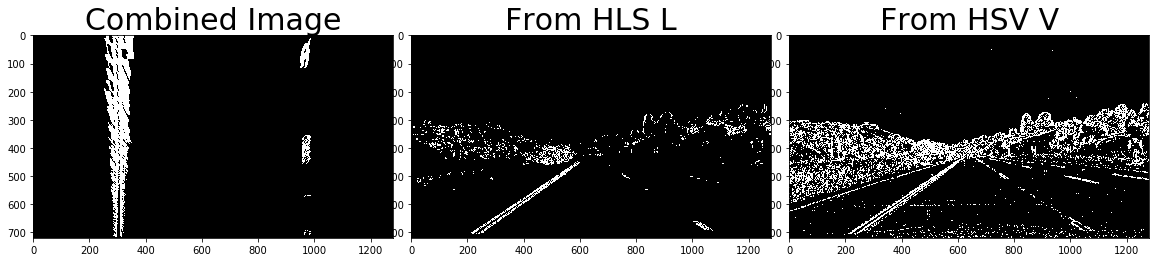

In [136]:
def update(n, thresh_min_hls, thresh_max_hls, thresh_min_hsv, thresh_max_hsv):
    #hls_s = cv2.cvtColor(unwarp(undistort(test_imgs[n])), cv2.COLOR_RGB2HLS)[:,:,2]
    #hsv_v = cv2.cvtColor(unwarp(undistort(test_imgs[n])), cv2.COLOR_RGB2HSV)[:,:,2]
    hls_s = cv2.cvtColor((undistort(test_imgs[n])), cv2.COLOR_RGB2HLS)[:,:,2]
    hsv_v = cv2.cvtColor((undistort(test_imgs[n])), cv2.COLOR_RGB2HSV)[:,:,2]
    img0 = abs_sobel_thresh(hls_s, 'x',thresh_min_hls, thresh_max_hls)
    img1 = abs_sobel_thresh(hsv_v, 'x',thresh_min_hsv, thresh_max_hsv)
    combined = np.zeros_like(img0)
    combined[((img0 == 1) & (img1 == 1))] = 1
    combined = unwarp(combined)
    
    # Visualize sobel direction threshold
    f, axs = plt.subplots(1, 3, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    axs = axs.ravel()
    axs[0].imshow(combined, cmap='gray')
    axs[0].set_title('Combined Image', fontsize=30)
    axs[1].imshow(img0, cmap='gray')
    axs[1].set_title('From HLS L', fontsize=30)
    axs[2].imshow(img1, cmap='gray')
    axs[2].set_title('From HSV V', fontsize=30)

interact(update, 
         n=(0,len(test_imgs)-1),
         thresh_min_hls=(0,255),
         thresh_max_hls=(0,255),
         thresh_min_hsv=(0,255),
         thresh_max_hsv=(0,255)
        )
#HLS:16-127, HSV:8-127

The Sobel on HLS:S channel gives the best result for this image.

In [8]:
def mag_thresh(img, sobel_kernel=3, mag_thresh_min=0, mag_thresh_max=255):
    # Convert to grayscale
    gray = img
    if len(img.shape)>2:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh_min) & (gradmag <= mag_thresh_max)] = 1

    # Return the binary image
    return binary_output

In [9]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_thresh(img, sobel_kernel=3, dir_thresh_min=0, dir_thresh_max=np.pi/2):
    # Grayscale
    gray = img
    if len(img.shape)>2:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh_min) & (absgraddir <= dir_thresh_max)] = 1

    # Return the binary image
    return binary_output

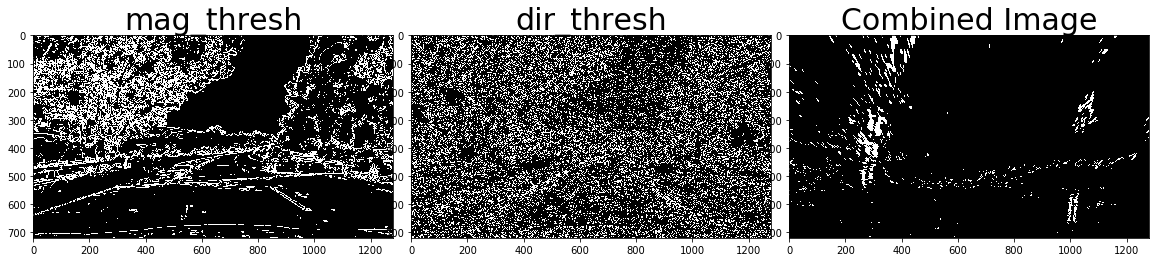

In [147]:
def update(n, kernel_size, dir_thresh_min, dir_thresh_max,mag_thresh_min, mag_thresh_max):
    hls_s = cv2.cvtColor(undistort(test_imgs[n]), cv2.COLOR_RGB2HLS)
    img0 = mag_thresh(hls_s, kernel_size,mag_thresh_min, mag_thresh_max)
    img1 = dir_thresh(hls_s, kernel_size,dir_thresh_min, dir_thresh_max)
    combined = np.zeros_like(img0)
    combined[(img0 == 1) & (img1 == 1)] = 1
    combined = unwarp(combined)
    # Visualize sobel direction threshold
    
    f, axs = plt.subplots(1, 3, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    axs = axs.ravel()
    axs[0].imshow(img0, cmap='gray')
    axs[0].set_title('mag_thresh', fontsize=30)
    axs[1].imshow(img1, cmap='gray')
    axs[1].set_title('dir_thresh', fontsize=30)
    axs[2].imshow(combined, cmap='gray')
    axs[2].set_title('Combined Image', fontsize=30)

interact(update, 
         n = (0,len(test_imgs)-1),
         kernel_size=(1,31,2),
         mag_thresh_min=(0,255),
         mag_thresh_max=(0,255),
         dir_thresh_min=(0,np.pi/2, 0.01),
         dir_thresh_max=(0,np.pi/2, 0.01)
        )
#k:3, dir:0.80-1.31, mag:15-150

In [10]:
#undistort->to HLS and HSV, sobel_x->combine->unwarp
def image_pipeline(img):
    undist = img  = undistort(img)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_s = hls[:,:,2] #S
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv_v = hsv[:,:,2] #V
    #bin_sv = np.zeros_like(hls_s)
    #bin_sv[((hls_s>=150)&(hls_s<=255)) & ((hsv_v>=130)&(hsv_v<=255))] = 1
    
    img0 = abs_sobel_thresh(hsv_v, 'x',10, 127)
    img1 = abs_sobel_thresh(hls_s, 'x',15, 127)
    #img2 = mag_thresh(hls_s, 3,20, 255)
    #img3 = dir_thresh(hsv_v, 3,0.80, 1.10)
    #img4 = dir_thresh(hls_s, 3,0.80, 1.20)
    combined = np.zeros_like(img0)
    combined[(img0 == 1) & (img1 == 1)] = 1
    #combined[(img0 == 1) & (img1 == 1) & (bin_sv == 1)] = 1
    combined = unwarp(combined)
    return combined, undist, img0, img1

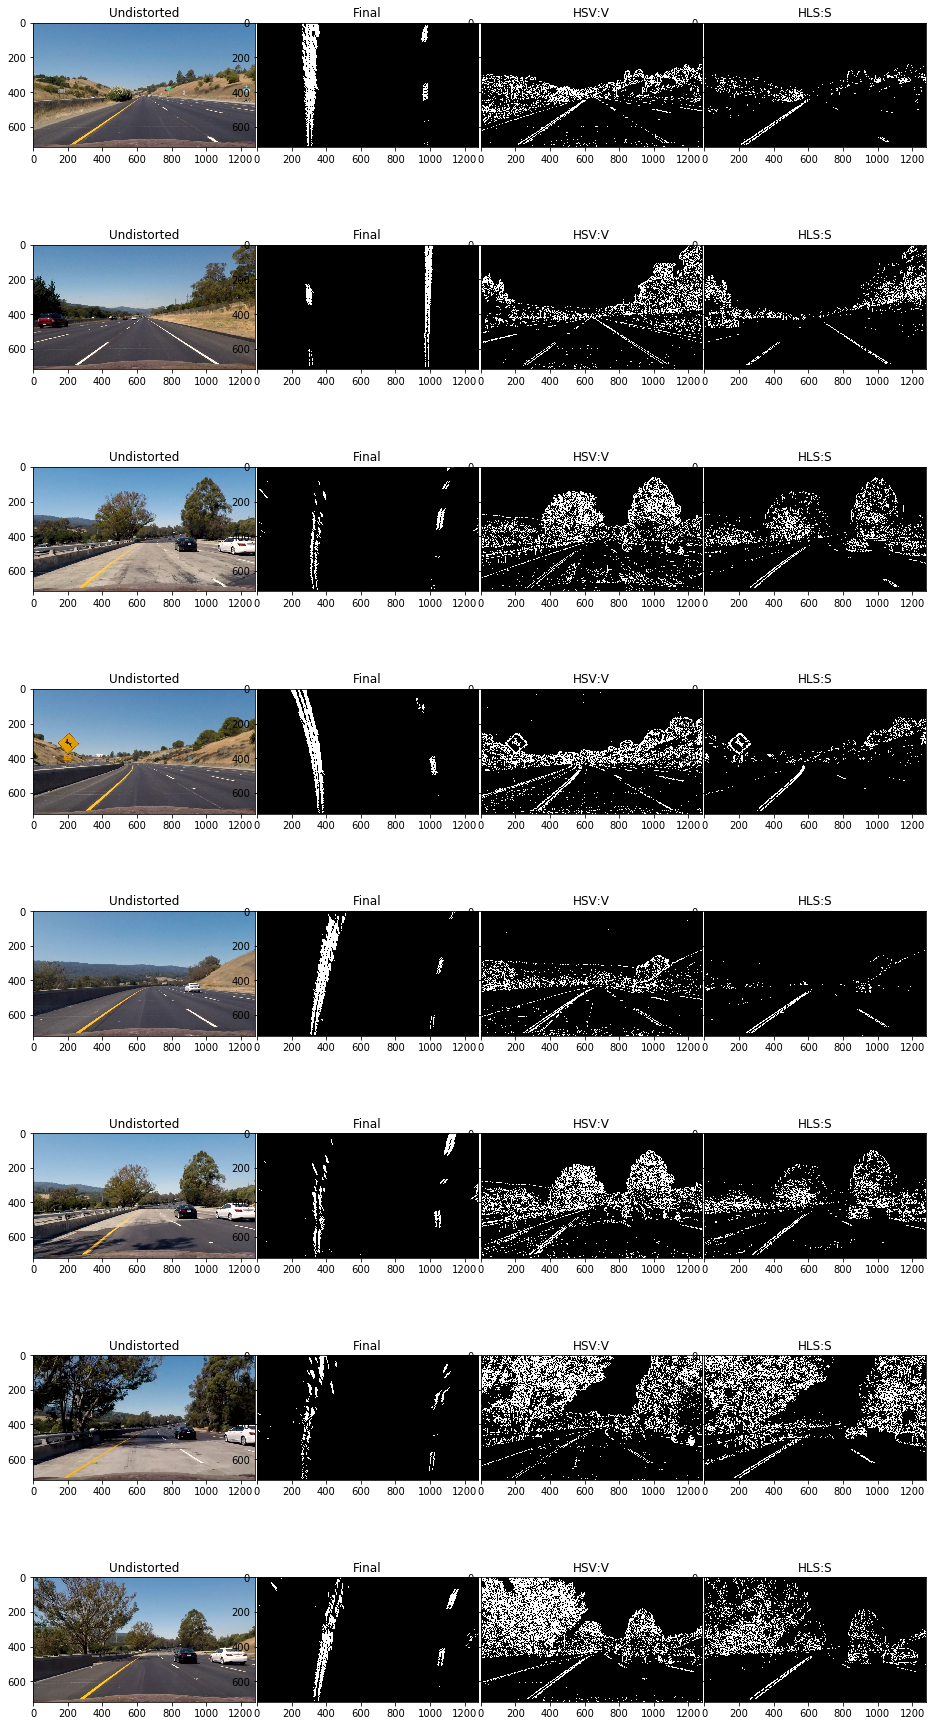

In [12]:
f, axs = plt.subplots(8, 4, figsize=(16,32))
f.subplots_adjust(hspace =.2, wspace=.01)
axs = axs.ravel()

for i,img in enumerate(test_imgs):
    img0, undist, img1, img2 = image_pipeline(img)
    axs[4*i].imshow(undist)
    axs[4*i].set_title('Undistorted')
    axs[4*i+1].imshow(img0,cmap='gray')
    axs[4*i+1].set_title('Final')
    axs[4*i+2].imshow(img1,cmap='gray')
    axs[4*i+2].set_title('HSV:V')
    axs[4*i+3].imshow(img2,cmap='gray')
    axs[4*i+3].set_title('HLS:S')


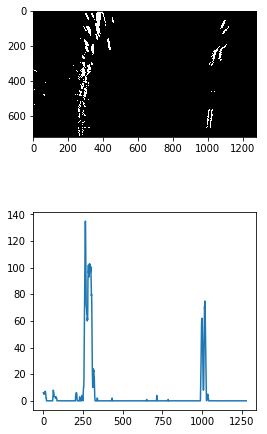

In [53]:
f, axs = plt.subplots(2, 1, figsize=(4,8))
f.subplots_adjust(hspace =.2, wspace=.01)
axs = axs.ravel()
comb, img0,img1,undist = image_pipeline(test_imgs[6])
axs[0].imshow(comb)
histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
axs[0].imshow(comb, cmap='gray')
axs[1].plot(histogram)

In [109]:
binary_warped = comb
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

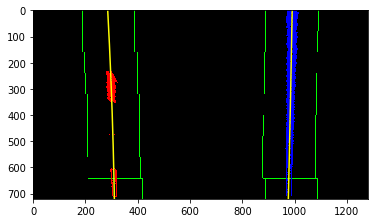

In [110]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [111]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

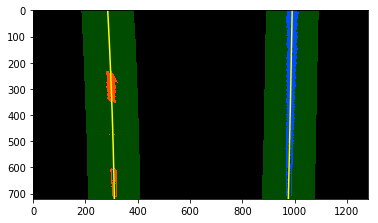

In [112]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [113]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

19746.9508849 113297.354081


In [114]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

6483.1987072 m 37182.2325303 m


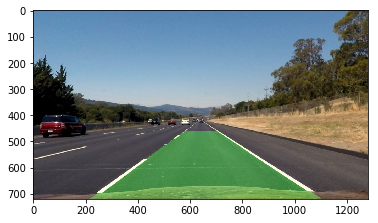

In [115]:
# Create an image to draw the lines on
warped = comb
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, MinV, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)

In [84]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None